In [75]:
import torch
from numpy import load
import pandas as pd
from torch import nn
import numpy as np
import json
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE;
from torch.utils.data import DataLoader

In [4]:
embedding = []
label_enc = []
data_count={}
count = 1
with open("output/embedding_extra_clean_seq_60.json",'r') as fr:
    for i in fr:
        i = json.loads(i)
        em, lab = i['embedding'], i['label']
        if lab in data_count:
            if data_count[lab]<10000:
                data_count[lab]+=1
            else:
                continue
        else:
            data_count[lab] = 1
        
        if count%1000 == 0:
            print(data_count)
        count+=1
        
#         if count%10000 == 0:
#             print(count/10000)
        
        embedding.append(i['embedding'])
        label_enc.append(i['label'])

{14: 10000, 7: 10000, 12: 10000, 15: 10000, 6: 10000, 1: 10000, 2: 4223, 4: 10000, 11: 873, 5: 10000, 3: 5704, 0: 7242, 9: 2166, 8: 2814, 10: 2253, 13: 6725}
{14: 10000, 7: 10000, 12: 10000, 15: 10000, 6: 10000, 1: 10000, 2: 4367, 4: 10000, 11: 906, 5: 10000, 3: 5901, 0: 7452, 9: 2220, 8: 2889, 10: 2331, 13: 6934}
{14: 10000, 7: 10000, 12: 10000, 15: 10000, 6: 10000, 1: 10000, 2: 4513, 4: 10000, 11: 935, 5: 10000, 3: 6068, 0: 7665, 9: 2287, 8: 2982, 10: 2400, 13: 7150}
{14: 10000, 7: 10000, 12: 10000, 15: 10000, 6: 10000, 1: 10000, 2: 4648, 4: 10000, 11: 964, 5: 10000, 3: 6245, 0: 7891, 9: 2349, 8: 3072, 10: 2472, 13: 7359}
{14: 10000, 7: 10000, 12: 10000, 15: 10000, 6: 10000, 1: 10000, 2: 4785, 4: 10000, 11: 987, 5: 10000, 3: 6400, 0: 8139, 9: 2413, 8: 3159, 10: 2544, 13: 7573}
{14: 10000, 7: 10000, 12: 10000, 15: 10000, 6: 10000, 1: 10000, 2: 4921, 4: 10000, 11: 1014, 5: 10000, 3: 6565, 0: 8366, 9: 2478, 8: 3244, 10: 2624, 13: 7788}
{14: 10000, 7: 10000, 12: 10000, 15: 10000, 6: 1000

In [ ]:
X_sm = embedding
y_sm = label_enc

In [ ]:
X_train_mask, X_test_mask, Y_train_mask, Y_test_mask = train_test_split(embedding,label_enc,test_size=0.2,random_state=77)

In [5]:
smote = SMOTE();
X_sm, y_sm = smote.fit_resample(embedding, label_enc)
# X_train_mask, X_test_mask, Y_train_mask, Y_test_mask = train_test_split(X_sm,y_sm,test_size=0.2,random_state=42)
# X_train = torch.FloatTensor(X_train_mask)
# X_test = torch.FloatTensor(X_test_mask)
# Y_train = torch.LongTensor(Y_train_mask)
# Y_test = torch.LongTensor(Y_test_mask)

In [6]:
del embedding
del label_enc

In [7]:
from sklearn.model_selection import StratifiedKFold

In [8]:
skf = StratifiedKFold(n_splits=5,shuffle=True)
skf.get_n_splits(X_sm, y_sm)

5

In [9]:
for train_index, test_index in skf.split(X_sm, y_sm):
    X_train, X_test = np.array(X_sm)[train_index], np.array(X_sm)[test_index]
    y_train, y_test = np.array(y_sm)[train_index], np.array(y_sm)[test_index]

In [ ]:
clf  = LogisticRegression(random_state=42,max_iter=10000,penalty='l2',C=0.1)
clf.fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
from xgboost import XGBClassifier

m = XGBClassifier(
    max_depth=2,
    gamma=2,
    eta=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5
)
m.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = m.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [143]:
import torch.nn as nn
import torch.nn.functional as F

class AnnModel(nn.Module):
    def __init__(self,in_features=4096,h1=1024,h2=128,out_features=16):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)
        self.fc2 = nn.Linear(h1,h2)
        self.out = nn.Linear(h2,out_features)
#         self.relu = nn.LeakyRelU(inplace=True)
        self.bn1 = nn.BatchNorm1d(num_features = h1)
        self.bn2 = nn.BatchNorm1d(num_features = h2)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self,x):
#         x = F.leaky_relu(self.fc1(x))
#         x = F.leaky_relu(self.fc2(x))
#         x = self.out(x)
#         return x

        x = F.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.out(x)
        return x

In [144]:
torch.manual_seed(32)
model = AnnModel()
model.cuda()
model.parameters

<bound method Module.parameters of AnnModel(
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=16, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)>

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

epochs = 10
n_batches = 2

losses = []
for epoch in range(epochs):
    for i in range(n_batches):
        local_X, local_y = X_train[i*n_batches:(i+1)*n_batches,], y_train[i*n_batches:(i+1)*n_batches,]

# for i in range(epochs):
#         print(local_X[0], local_y[0])
        y_pred = model.forward(torch.FloatTensor(local_X).cuda())
        loss = criterion(y_pred, torch.LongTensor(local_y).cuda())
    
    losses.append(loss)
    if epoch%10==0:
        print(f"epoch: {i} and loss {loss}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

torch.cuda.empty_cache()

2
2
epoch: 1 and loss 2.7433876991271973
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [205]:
import torch.nn as nn
import torch.nn.functional as F

class AnnModel(nn.Module):
    def __init__(self,in_features=4096,h1=1024,h2=128,out_features=16):
        super().__init__()
#         self.fc1 = nn.Linear(in_features,h1)
#         self.fc2 = nn.Linear(h1,h2)
#         self.out = nn.Linear(h1,out_features)
#         self.relu = nn.LeakyRelU(inplace=True)
#         self.bn1 = nn.BatchNorm1d(num_features = h1)
#         self.bn2 = nn.BatchNorm1d(num_features = h2)
#         self.dropout = nn.Dropout(0.5)
        self.out2 = nn.Linear(in_features,out_features)
        self.bn3 = nn.BatchNorm1d(num_features = out_features)
        
    def forward(self,x):
#         x = F.leaky_relu(self.fc1(x))
#         x = F.leaky_relu(self.fc2(x))
#         x = self.out(x)
#         return x

#         x = F.leaky_relu(self.bn1(self.fc1(x)))
#         x = self.dropout(x)
#         x = F.leaky_relu(self.bn2(self.fc2(x)))
#         x = self.dropout(x)
        x = self.bn3(self.out2(x))
        
#         print(x)
        return x

In [206]:
torch.manual_seed(32)
model = AnnModel()
model.cuda()
model.parameters

<bound method Module.parameters of AnnModel(
  (out2): Linear(in_features=4096, out_features=16, bias=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)>

In [211]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-6)

epochs = 100
n_batches = 5

train_losses = []
train_correct = []
test_losses = []
test_correct = []
slice = len(X_train)


dataload_x = DataLoader(X_train[:slice],batch_size=n_batches)
dataload_y = DataLoader(y_train[:slice],batch_size=n_batches)

test_dataload_x = DataLoader(X_test[:slice],batch_size=n_batches)
test_dataload_y = DataLoader(y_test[:slice],batch_size=n_batches)

for epoch in range(epochs):
    trn_corr = 0
    test_corr = 0
    
    for local_X, local_Y in zip(dataload_x,dataload_y):
        y_pred = model(local_X.float().cuda())
        loss = criterion(y_pred, torch.LongTensor(local_Y).cuda())
        
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == local_Y.cuda()).sum()
        trn_corr+= batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
#     print(f"epoch: {epoch} and loss {loss}")
    
    with torch.no_grad():
        for testing_x, testing_y in zip(test_dataload_x,test_dataload_y):
            y_val = model(testing_x.float().cuda())
            predicted = torch.max(y_val.data,1)[1]
            batch_corr= (predicted == testing_y.cuda()).sum()
            test_corr+=batch_corr
            
    loss = criterion(y_val,testing_y.cuda())
    test_losses.append(loss)
    test_correct.append(test_corr)
    
    print(f"epoch: {epoch} and loss {loss} and train correct {trn_corr} and test correct {test_corr}")

torch.cuda.empty_cache()

epoch: 0 and loss 2.801741361618042 and train correct 13390 and test correct 2698
epoch: 1 and loss 2.787855863571167 and train correct 12971 and test correct 2694
epoch: 2 and loss 2.7802064418792725 and train correct 12942 and test correct 2673
epoch: 3 and loss 2.7745232582092285 and train correct 12971 and test correct 2658
epoch: 4 and loss 2.769712209701538 and train correct 13051 and test correct 2650


KeyboardInterrupt: 

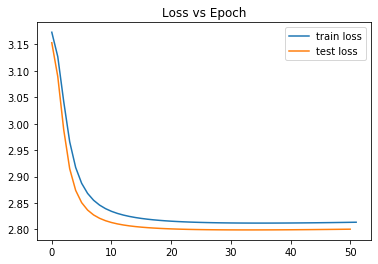

In [209]:
plt.plot(train_losses,label="train loss")
plt.plot(test_losses,label="test loss")
plt.title("Loss vs Epoch")
plt.legend();

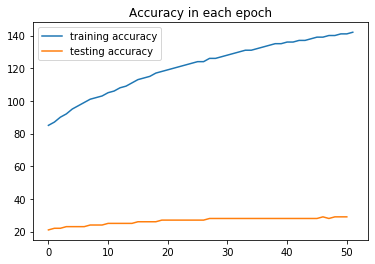

In [210]:
plt.plot([t/100 for t in train_correct],label="training accuracy")
plt.plot([t/100 for t in test_correct], label="testing accuracy")
plt.title("Accuracy in each epoch")
plt.legend();

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(epochs),losses)
plt.xlabel("EPOCH%100")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")

In [187]:
with torch.no_grad():
    y_eval = model.forward(torch.FloatTensor(X_test).cuda())
    loss = criterion(y_eval,torch.LongTensor(y_test).cuda())

In [188]:
y_pred = []
for i in y_eval:
    y_pred.append(np.argmax(i.cpu()))

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 6.79%


In [297]:
del model
torch.cuda.empty_cache()

In [32]:
np.save("output/embedding_160k_balanced.npy",X_sm)

In [212]:
np.save("output/label_160k_balanced.npy",y_sm)

In [221]:
class LSTM_Classifier(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers=2, 
                 bidirectional=True, dropout=0.5):
        super().__init__()
         #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        #activation function
        self.act = nn.Sigmoid()
    
    
    def forward(self, embedding):
                
        packed_output, (hidden, cell) = self.lstm(embedding)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        
        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
        dense_outputs=self.fc(hidden)

        #Final activation function
        outputs=self.act(dense_outputs)
        
        return outputs

In [286]:
embedding_dim = 4096
num_hidden_nodes = 32
num_output_nodes = 16
num_layers = 2
bidirection = True
dropout = 0.5

#instantiate the model
model = LSTM_Classifier(embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, bidirectional = True, dropout = dropout)
model.cuda()

LSTM_Classifier(
  (lstm): LSTM(4096, 32, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=64, out_features=16, bias=True)
  (act): Sigmoid()
)

In [287]:
#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,083,408 trainable parameters


In [296]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-6)

epochs = 100
n_batches = 100

train_losses = []
train_correct = []
test_losses = []
test_correct = []
slice = len(X_train)


dataload_x = DataLoader(X_train[:slice],batch_size=n_batches)
dataload_y = DataLoader(y_train[:slice],batch_size=n_batches)

test_dataload_x = DataLoader(X_test[:slice],batch_size=n_batches)
test_dataload_y = DataLoader(y_test[:slice],batch_size=n_batches)

for epoch in range(epochs):
    trn_corr = 0
    test_corr = 0
    
    for local_X, local_Y in zip(dataload_x,dataload_y):
        local_X = local_X.unsqueeze(2).view(n_batches,1,4096)

        y_pred = model(local_X.float().cuda())
        loss = criterion(y_pred, torch.LongTensor(local_Y).cuda())
        
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == local_Y.cuda()).sum()
        trn_corr+= batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
#     print(f"epoch: {epoch} and loss {loss}")
    
    with torch.no_grad():
        for testing_x, testing_y in zip(test_dataload_x,test_dataload_y):
            y_val = model(testing_x.unsqueeze(2).view(n_batches,1,4096).float().cuda())
            predicted = torch.max(y_val.data,1)[1]
            batch_corr= (predicted == testing_y.cuda()).sum()
            test_corr+=batch_corr
            
    loss = criterion(y_val,testing_y.cuda())
    test_losses.append(loss)
    test_correct.append(test_corr)
    
    print(f"epoch: {epoch} and loss {loss} and train correct {trn_corr} and test correct {test_corr}")

torch.cuda.empty_cache()

epoch: 0 and loss 2.7678768634796143 and train correct 7282 and test correct 1993
epoch: 1 and loss 2.767824649810791 and train correct 7751 and test correct 1999
epoch: 2 and loss 2.767810106277466 and train correct 7919 and test correct 1985
epoch: 3 and loss 2.7675631046295166 and train correct 8007 and test correct 1986
epoch: 4 and loss 2.766683340072632 and train correct 8012 and test correct 2004
epoch: 5 and loss 2.7659010887145996 and train correct 8078 and test correct 2012
epoch: 6 and loss 2.765482187271118 and train correct 7995 and test correct 1965


KeyboardInterrupt: 

In [227]:
agh = torch.Tensor([[1],[2]])

In [232]:
agh.shape

torch.Size([2, 1])

In [271]:
x1 = torch.zeros(2, 2)
print(x1)
x2 = torch.unsqueeze(x1,2)
x2.shape

tensor([[0., 0.],
        [0., 0.]])


torch.Size([2, 2, 1])

In [272]:
x2.unsqueeze(2).shape

torch.Size([2, 2, 1, 1])

In [280]:
x2.view(1,1,2,2).shape

torch.Size([1, 1, 2, 2])